In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class OccupancyMap:
    
    def __init__(self, w, h, res):
        self.w = w
        self.h = h
        self.res = res
        self.grid = np.zeros((int(self.w/self.res), int(self.h/self.res)))
        
    def plot_probability(self):
        plt.imshow(self.grid.T, cmap=plt.get_cmap('binary'), extent=[
            -self.w, self.w, -self.h, self.h])
        plt.xlabel('x, m')
        plt.ylabel('y, m')
        plt.axis('equal')
        plt.grid()

    def plot_occupied(self, thresh=0.5):
        plt.imshow(self.grid.T > thresh, cmap=plt.get_cmap('binary'), extent=[
            -self.w, self.w, -self.h, self.h])
        plt.xlabel('x, m')
        plt.ylabel('y, m')
        plt.axis('equal')
        plt.grid()

    def get_ij(self, x, y):
        i = int(np.floor((x + self.w)/(2*self.res)))
        j = int(np.floor((-y + self.h)/(2*self.res)))
        if i < 0 or i >= self.grid.shape[0]:
            raise ValueError('x out of bounds')
        if j < 0 or j >= self.grid.shape[1]:
            raise ValueError('y out of bounds')
        return i, j
    
    def get_probability(self, x, y):
        i, j = self.get_ij(x, y)
        return self.grid[i, j]

    def prob_update(self, i, j, prob):
        p0 = self.grid[i,j]
        alpha = 0.5
        p = alpha*p0 + (1 - alpha)*prob
        if p > 1:
            p = 1
        elif p < 0:
            p = 0
        self.grid[i, j] = p

    def measure(self, x, y, theta, dist):
        p = np.array([x, y])
        R = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]])
        intersections = []
        t_list = np.arange(0, dist, self.res/2)
        for i_t, t in enumerate(t_list):
            m = p + R@np.array([t, 0])
            if i_t == len(t_list) - 1:
                # positive information where we see things
                prob = 1
            else:
                # negative information, where we don't see anything
                prob = 0
            try:
                i, j = self.get_ij(m[0], m[1])
                if len(intersections) == 0 or intersections[-1] != (i, j):
                    intersections += [(i, j, prob)]
            except ValueError as e:
                continue
        for i, m in enumerate(intersections):
            self.prob_update(i=m[0], j=m[1], prob=m[2])
    
    def get_occupied(self, thresh=0.5):
        return self.grid > thresh

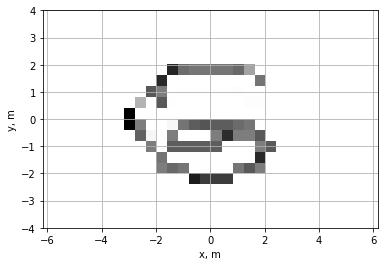

In [4]:
m = OccupancyMap(w=4, h=4, res=0.2)


t_vect = np.arange(0, 10, 0.1)
for t in t_vect:
    
    # SE(2) position of rover (x, y, theta)
    x = 2*np.cos(t)
    y = np.sin(t)
    theta = np.deg2rad(1)

    # this will change as robot gets new data
    distances = [0.1, 1.2, 1.1, 1]
    
    # body fixed angles of sensors
    angles = [0, -90, 90, 180]
    for angle, dist in zip(angles, distances):
        if dist > 1.4:
            continue
        m.measure(x, y, theta + np.deg2rad(angle), dist)

m.plot_probability()

In [7]:
np.max(m.grid)

0.984375

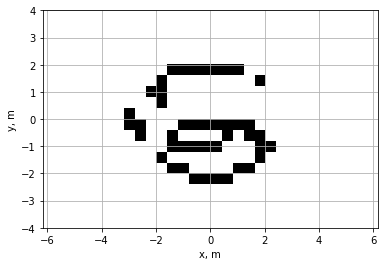

In [8]:
m.plot_occupied(thresh=0.5)

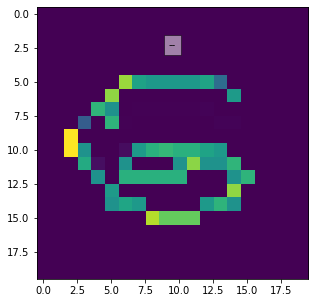

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
title = ax.text(0.5,0.85, "--", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                transform=ax.transAxes, ha="center")
im = ax.imshow(m.grid.T, animated=True)

In [14]:
grid = m.grid
grid[0,0] = 0
im.set_array(grid)
plt.show()